- train for 2 epochs, batch size 8, at 5e-6, with 10% warmup val intersects train loss, acc 0.81
- train for 3 epoch, same settings, acc 0.84

- used cleaned colour datset only
- 0.2 for eval data set

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    epochs = [i+1 for i in range(len(train_loss))]
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, train_loss, marker='o', label='Train Loss', color='blue', linestyle='-')
    plt.plot(epochs, val_loss, marker='s', label='Validation Loss', color='red', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

train_c_path = '/kaggle/input/train-colour/train_cleaned_color_resized'
test_c_path = '/kaggle/input/test-colour/test_cleaned_color_resized'
train_bw_path = '/kaggle/input/train-black1/train_cleaned_black_resized'
test_bw_path = '/kaggle/input/test-black/test_cleaned_black_resized'
# train_c_uc_path = '/kaggle/input/train-unclean-c-resized/train_resized'
# test_c_uc_path = '/kaggle/input/test-unclean-c-resized/test_resized'

train_bw_df = pd.DataFrame(os.listdir(train_bw_path), columns=['filename'])
test_bw_df = pd.DataFrame(os.listdir(test_bw_path), columns=['filename'])
train_c_df = pd.DataFrame(os.listdir(train_c_path), columns=['filename'])
test_c_df = pd.DataFrame(os.listdir(test_c_path), columns=['filename'])
# train_c_uc_df = pd.DataFrame(os.listdir(train_c_uc_path), columns=['filename'])
# test_c_uc_df = pd.DataFrame(os.listdir(test_c_uc_path), columns=['filename'])

# get labels
train_bw_df["captcha_text"] = train_bw_df["filename"].str[:-6]
test_bw_df["captcha_text"] = test_bw_df["filename"].str[:-6]
train_c_df["captcha_text"] = train_c_df["filename"].str[:-6]
test_c_df["captcha_text"] = test_c_df["filename"].str[:-6]
# train_c_uc_df["captcha_text"] = train_c_uc_df["filename"].str[:-6]
# test_c_uc_df["captcha_text"] = test_c_uc_df["filename"].str[:-6]

# get complete file path
train_bw_df['filename'] = train_bw_df['filename'].apply(lambda x: os.path.join(train_bw_path, x))
test_bw_df['filename'] = test_bw_df['filename'].apply(lambda x: os.path.join(test_bw_path, x))
train_c_df['filename'] = train_c_df['filename'].apply(lambda x: os.path.join(train_c_path, x))
test_c_df['filename'] = test_c_df['filename'].apply(lambda x: os.path.join(test_c_path, x))
# train_c_uc_df['filename'] = train_c_uc_df['filename'].apply(lambda x: os.path.join(train_c_uc_path, x))
# test_c_uc_df['filename'] = test_c_uc_df['filename'].apply(lambda x: os.path.join(test_c_uc_path, x))

#combine bw and colour if needed
train_df = pd.concat([train_c_df], ignore_index=True)
test_df = pd.concat([test_c_df], ignore_index=True)

# # clean duplicates
train_df = train_df[~train_df["filename"].str.endswith("(1).png")]
test_df = test_df[~test_df["filename"].str.endswith("_Store")]

# # print to check
print(f'Train entries: {train_df.shape[0]} | Test entries: {test_df.shape[0]}')
print(train_df.head()) #shld be
print(test_df.head()) #shld be

Train entries: 7833 | Test entries: 1967
                                            filename captcha_text
0  /kaggle/input/train-colour/train_cleaned_color...        518h3
1  /kaggle/input/train-colour/train_cleaned_color...      mdm8bay
2  /kaggle/input/train-colour/train_cleaned_color...       529ua9
3  /kaggle/input/train-colour/train_cleaned_color...        fl66b
4  /kaggle/input/train-colour/train_cleaned_color...       wh2stg
                                            filename captcha_text
0  /kaggle/input/test-colour/test_cleaned_color_r...      q02a9jk
1  /kaggle/input/test-colour/test_cleaned_color_r...     nowqcrpn
2  /kaggle/input/test-colour/test_cleaned_color_r...      jpquvw6
3  /kaggle/input/test-colour/test_cleaned_color_r...      4edetz3
4  /kaggle/input/test-colour/test_cleaned_color_r...       l2dxd3


In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
import torch

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed') #microsoft/trocr-base-handwritten
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'using device: {device}')

# training
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

using device: cuda


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

# set df here
df = train_df

class CaptchaDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filename']).convert("RGB")
        text = row['captcha_text']

        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze(0)
        labels = self.processor.tokenizer(text, return_tensors="pt").input_ids.squeeze(0)
        return {"pixel_values": pixel_values, "labels": labels}


def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    labels = [item["labels"] for item in batch]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=processor.tokenizer.pad_token_id)

    return {"pixel_values": pixel_values, "labels": labels_padded}

dataset = CaptchaDataset(df, processor)

train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)


In [5]:
len(train_dataset)

6266

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


starting epoch 1, s to stop execution 


100%|██████████| 784/784 [09:31<00:00,  1.37it/s]


Epoch 1, Train Loss: 1.6856
Epoch 1, Validation Loss: 0.5710


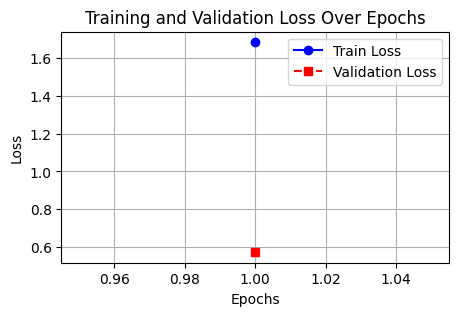

starting epoch 2, s to stop execution 


100%|██████████| 784/784 [09:33<00:00,  1.37it/s]


Epoch 2, Train Loss: 0.4163
Epoch 2, Validation Loss: 0.4399


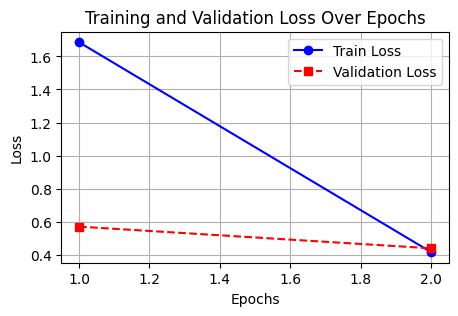

starting epoch 3, s to stop execution 


100%|██████████| 784/784 [09:34<00:00,  1.36it/s]


Epoch 3, Train Loss: 0.2270
Epoch 3, Validation Loss: 0.4049


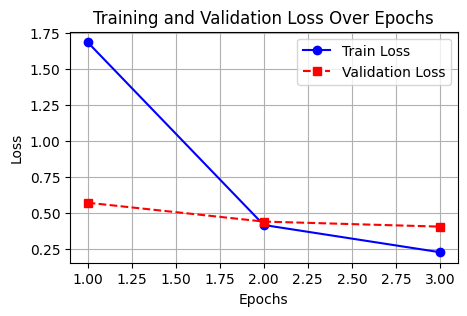

starting epoch 4, s to stop execution s


In [6]:
from transformers import AdamW, get_scheduler
from tqdm import tqdm
import torch

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)  #lower learning rate more, + add weight decay
epochs = 5
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps) #added warmup steps
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

tl_store = []
vl_store = []

for epoch in range(epochs):
    action = input(f"starting epoch {epoch+1}, s to stop execution")
    if action == "s":
        break

    model.train()
    train_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        # print(pixel_values.shape)
        # print(pixel_values)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation Step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")
    tl_store.append(avg_train_loss)
    vl_store.append(avg_val_loss)
    plot_loss(tl_store, vl_store)


In [ ]:
import torch
from tqdm.auto import tqdm

tqdm.pandas()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_batch(file_paths):
    images = [Image.open(fp).convert("RGB") for fp in file_paths]
    pixel_values = processor(images, return_tensors="pt", padding=True).pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_texts

batch_size = 16
predictions = []

for i in tqdm(range(0, len(test_bw_df), batch_size)):
    batch_files = test_bw_df['filename'][i:i+batch_size].tolist()
    batch_preds = predict_batch(batch_files)
    predictions.extend(batch_preds)

test_df['predicted_text_printed'] = predictions


  0%|          | 0/123 [00:00<?, ?it/s]

In [8]:
test_df

,filename,captcha_text,predicted_text_printed
0,/kaggle/input/test-colour/test_cleaned_color_r...,q02a9jk,qo2a1sk
1,/kaggle/input/test-colour/test_cleaned_color_r...,nowqcrpn,n0wqcrpn
2,/kaggle/input/test-colour/test_cleaned_color_r...,jpquvw6,jpquvw6
3,/kaggle/input/test-colour/test_cleaned_color_r...,4edetz3,4edetz3
4,/kaggle/input/test-colour/test_cleaned_color_r...,l2dxd3,12dxd3
...,...,...,...
1962,/kaggle/input/test-colour/test_cleaned_color_r...,o1s3al0,o1a3el0
1963,/kaggle/input/test-colour/test_cleaned_color_r...,x4ou7j,x0ov0j
1964,/kaggle/input/test-colour/test_cleaned_color_r...,lzjyzk9n,lzjyzk3v
1965,/kaggle/input/test-colour/test_cleaned_color_r...,w7na,w7na


In [9]:
test_df.to_csv("predictions_c_train_stag1.csv", index=False)

In [ ]:
model.save_pretrained("trocr_captcha_model")
processor.save_pretrained("trocr_captcha_model")

In [ ]:
import shutil

shutil.make_archive("trocr_captcha_model", 'zip', "trocr_captcha_model")

In [10]:
import pandas as pd
file = "/kaggle/working/predictions_c_train_stag1.csv"
df = pd.read_csv(file, sep=",")
df

,filename,captcha_text,predicted_text_printed
0,/kaggle/input/test-colour/test_cleaned_color_r...,q02a9jk,qo2a1sk
1,/kaggle/input/test-colour/test_cleaned_color_r...,nowqcrpn,n0wqcrpn
2,/kaggle/input/test-colour/test_cleaned_color_r...,jpquvw6,jpquvw6
3,/kaggle/input/test-colour/test_cleaned_color_r...,4edetz3,4edetz3
4,/kaggle/input/test-colour/test_cleaned_color_r...,l2dxd3,12dxd3
...,...,...,...
1962,/kaggle/input/test-colour/test_cleaned_color_r...,o1s3al0,o1a3el0
1963,/kaggle/input/test-colour/test_cleaned_color_r...,x4ou7j,x0ov0j
1964,/kaggle/input/test-colour/test_cleaned_color_r...,lzjyzk9n,lzjyzk3v
1965,/kaggle/input/test-colour/test_cleaned_color_r...,w7na,w7na


In [11]:
df["predicted_text_printed"] = df["predicted_text_printed"].map(str.lower)

In [12]:
(df[df["predicted_text_printed"].apply(lambda text: any(c.isupper() or not c.isalnum() for c in text))])

,filename,captcha_text,predicted_text_printed
833,/kaggle/input/test-colour/test_cleaned_color_r...,xxmao,**7ao


In [ ]:
def character_accuracy(actual, predicted):
    min_len = min(len(actual), len(predicted))
    correct = sum([1 if actual[i] == predicted[i] else 0 for i in range(min_len)])
    return correct

chr_acc = [character_accuracy(row['captcha_text'], row['predicted_text_printed']) for _, row in df.iterrows()]
df['chr_acc'] = chr_acc

print(df[['captcha_text', 'predicted_text_printed', 'chr_acc', ]].head())


  captcha_text predicted_text_printed  chr_acc
0      q02a9jk                qo2a1sk        4
1     nowqcrpn               n0wqcrpn        7
2      jpquvw6                jpquvw6        7
3      4edetz3                4edetz3        7
4       l2dxd3                 12dxd3        5


In [14]:
sum_chr_acc = df['chr_acc'].sum()
sum_len_captcha_text = df['captcha_text'].apply(len).sum()

print(f"chr_acc: {sum_chr_acc /sum_len_captcha_text}")

chr_acc: 0.8413787262872628


In [15]:
total_matches = (df['captcha_text'] == df['predicted_text_printed']).sum()

print(f"complete matches: {total_matches} / {len(df)}, {total_matches/len(df)}")

complete matches: 990 / 1967, 0.5033045246568378


In [16]:
from nltk.metrics import edit_distance

def char_accuracy_MED(actual, predicted):
    return 1 - (edit_distance(actual, predicted) / max(len(actual), len(predicted)))

chr_acc_med = [char_accuracy_MED(row['captcha_text'], row['predicted_text_printed']) for _, row in df.iterrows()]
df['chr_acc_med'] = chr_acc_med
df

,filename,captcha_text,predicted_text_printed,chr_acc,chr_acc_med
0,/kaggle/input/test-colour/test_cleaned_color_r...,q02a9jk,qo2a1sk,4,0.571429
1,/kaggle/input/test-colour/test_cleaned_color_r...,nowqcrpn,n0wqcrpn,7,0.875000
2,/kaggle/input/test-colour/test_cleaned_color_r...,jpquvw6,jpquvw6,7,1.000000
3,/kaggle/input/test-colour/test_cleaned_color_r...,4edetz3,4edetz3,7,1.000000
4,/kaggle/input/test-colour/test_cleaned_color_r...,l2dxd3,12dxd3,5,0.833333
...,...,...,...,...,...
1962,/kaggle/input/test-colour/test_cleaned_color_r...,o1s3al0,o1a3el0,5,0.714286
1963,/kaggle/input/test-colour/test_cleaned_color_r...,x4ou7j,x0ov0j,3,0.500000
1964,/kaggle/input/test-colour/test_cleaned_color_r...,lzjyzk9n,lzjyzk3v,6,0.750000
1965,/kaggle/input/test-colour/test_cleaned_color_r...,w7na,w7na,4,1.000000


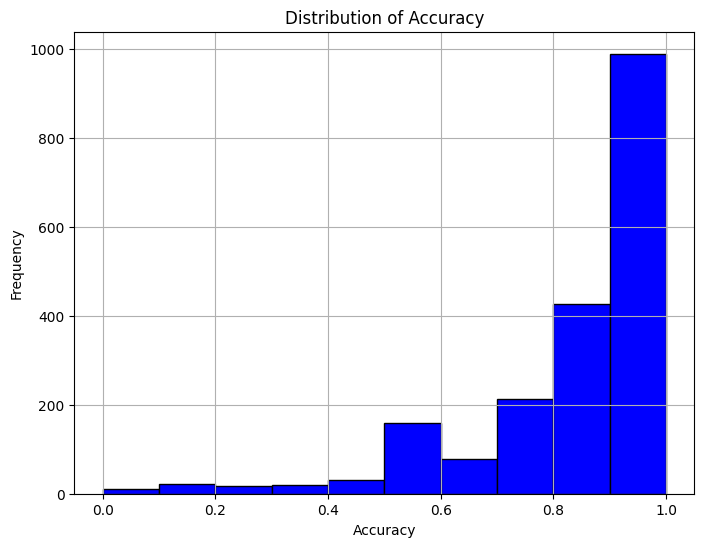

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(df['chr_acc_med'], bins=10, color='b', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracy')
plt.grid(True)
plt.show()

In [18]:
df.to_csv("predictions_c_train_stag1_full_2epoch.csv", index=False)